# 4.16 “Se não está funcionando, aumenta a temperatura que dá certo” — Autor anônimo
<div style="text-align: justify">

### Objetivo: 
Proponha um problema de otimização com restrição. Implemente uma
rotina de recozimento simulado (simulated annealing) no código de algoritmo genético
desenvolvido nesta disciplina (isto é, não é para usar o DEAP). Utilize de um algoritmo
genético com recozimento simulado para resolver o problema com restrição escolhido.
Aproveite e conte para o leitor como funciona o processo de recozimento simulado que
você implementou.

## Resolução
<div style="text-align: justify">

Para resolver esse problema iremos utilizar o já resolvido problema dos caixeiros que preferem cidades ímpares, com a clara restrição de que os indivíduos precisam viajam para as cidades ímpares antes de começar a interagir com as cidades pares. Para tentar otimizar esse problema iremos aplicar o algoritmo de recozimento simulado.

#### Contextualização
<div style="text-align: justify">

Para iniciar, primeiro iremos definir do que exatamente se trata esse algoritmo.
O algoritmo aqui apresentado, o recozimento simulado (ou Simulated Annealing, em inglês), é inspirado em uma técnica física utilizada no processo de fabricação de ligas metálicas. Nesse processo, a liga é resfriada lentamente após sua formação, permitindo que os átomos se organizem em um estado de menor energia. Isso evita que o material fique preso em configurações de energia subótima, conhecidas como mínimos locais, o que pode acontecer quando o resfriamento ocorre de forma muito rápida.

Ao adaptar esse conceito para problemas de otimização, o recozimento simulado busca encontrar a melhor solução (ou uma solução suficientemente boa) para um problema, evitando ficar preso em ótimos locais. Ele faz isso aceitando, com certa probabilidade, soluções piores nas primeiras etapas da busca — uma forma de permitir que o algoritmo escape de mínimos locais e explore melhor o espaço de soluções.

Para implementar essa técnica em Python, analisamos iterativamente os vizinhos de um ponto (solução atual) e verificamos se a nova solução melhora ou piora a função objetivo. Caso melhore, ela é aceita. Caso piore, ainda pode ser aceita com uma probabilidade que depende da diferença entre os valores e da "temperatura" atual do sistema, que vai diminuindo com o tempo. Assim, o algoritmo começa explorando amplamente o espaço de soluções e, com o tempo, vai se tornando mais seletivo, focando no refinamento das melhores soluções encontradas. 

Probabilidade adotada em [1] para a implementação do algoritmo:

$$
P = \exp\left(-\frac{\Delta E}{T}\right)
$$

### Implementação

In [1]:
from pprint import pprint
from functools import partial
from itertools import permutations

from funcoes_caixeiro_impar import cria_cidades
from funcoes_caixeiro_impar import populacao_caixeiro as cria_populacao
from funcoes_caixeiro_impar import funcao_objetivo_pop_caixeiro
from funcoes_caixeiro_impar import funcao_objetivo_caixeiro
from funcoes_caixeiro_impar import selecao_torneio_min as funcao_selecao
from funcoes_caixeiro_impar import cruzamento_ponto_simples as funcao_cruzamento
from funcoes_caixeiro_impar import mutacao_troca as funcao_mutacao
from funcoes_caixeiro_impar import plota_trajeto

In [2]:
TAMANHO_POPULACAO = 100
NUM_GERACOES = 500
CHANCE_DE_CRUZAMENTO = 0.5
CHANCE_DE_MUTACAO = 0.05
TAMANHO_TORNEIO = 3

In [3]:
NUM_CIDADES = 10
CIDADES = cria_cidades(NUM_CIDADES)
populacao = cria_populacao(TAMANHO_POPULACAO, CIDADES)

In [4]:
funcao_objetivo = partial(funcao_objetivo_pop_caixeiro, cidades=CIDADES)
funcao_objetivo_individuo = partial(funcao_objetivo_caixeiro, cidades=CIDADES)

#### Função gerar vizinho
<div style="text-align: justify">

A função `gerar_vizinho` gera indivíduos que apresentam uma cidade trocada em relação à saída de uma geração do nosso algoritmo genético. Ela foi criada para trocar valores ímpares com valores pares. Isso será utilizado na etapa de Simulated Annealing para gerar pequenas modificações e posterior analise dos valores obtidos.

In [5]:
import random

def gerar_vizinho(atual):
    sorteio = random.choice(['Par', 'Impar'])
    vizinho = atual[:]

    if sorteio == 'Par':
        trocar_1 = random.choice(list(range(2, len(atual), 2)))
        trocar_2 = random.choice(list(range(2, len(atual), 2)))
    else:
        trocar_1 = random.choice(list(range(1, len(atual), 2)))
        trocar_2 = random.choice(list(range(1, len(atual), 2)))

    vizinho[trocar_1], vizinho[trocar_2] = vizinho[trocar_2], vizinho[trocar_1]

    return vizinho

### Função recozimento simulado
<div style="text-align: justify">

Aqui temos a construção da principal estrutura do projeto. A função é responsável por otimizar o melhor indivíduo obtido durante o processo do algoritmo genético. Ela recebe como parâmetros: o indivíduo, a função objetivo, a temperatura inicial, a temperatura final e o fator de resfriamento. Enquanto a temperatura não atingir o valor final, o algoritmo continuará gerando vizinhos, calculando seus valores de fitness e atualizando o melhor resultado encontrado. Quanto menor for a temperatura, menor será a probabilidade de aceitar uma solução com desempenho inferior, promovendo assim uma busca mais refinada por ótimos locais.

In [6]:
import math

def recozimento_simulado(individuo, funcao_objetivo, T_inicial=1.0, T_final=0.01, resfriamento=0.9):
    atual = individuo[:]
    melhor = individuo[:]
    T = T_inicial

    while T > T_final:
        vizinho = gerar_vizinho(atual)
        delta = funcao_objetivo(vizinho) - \
                funcao_objetivo(atual)

        if delta > 0 or random.random() < math.exp(delta / T):
            atual = vizinho
            if funcao_objetivo(atual) < funcao_objetivo(melhor):
                melhor = atual

        T *= resfriamento

    return melhor


In [7]:
hall_da_fama = []

for n in range(NUM_GERACOES):
    
    # Seleção
    fitness = funcao_objetivo(populacao)        
    selecionados = funcao_selecao(populacao, fitness, TAMANHO_TORNEIO)
    
    # Cruzamento
    proxima_geracao = []
    for pai, mae in zip(selecionados[::2], selecionados[1::2]):
        individuo1, individuo2 = funcao_cruzamento(pai, mae, CHANCE_DE_CRUZAMENTO)
        proxima_geracao.append(individuo1)
        proxima_geracao.append(individuo2)
    
    # Mutação
    funcao_mutacao(proxima_geracao, CHANCE_DE_MUTACAO)
    
    # Atualização do hall da fama
    fitness = funcao_objetivo(proxima_geracao)
        
    menor_fitness = min(fitness)
    indice = fitness.index(menor_fitness)

    melhor = recozimento_simulado(proxima_geracao[indice], funcao_objetivo_individuo, T_inicial=1.0, T_final=0.01, resfriamento=0.9)
   
    hall_da_fama.append(melhor)    
    
    # Encerramento
    populacao = proxima_geracao


Melhor individuo obtido por algoritmos genéticos:
['Cidade 00', 'Cidade 03', 'Cidade 07', 'Cidade 01', 'Cidade 09', 'Cidade 05', 'Cidade 08', 'Cidade 04', 'Cidade 02', 'Cidade 06'] com distância: 1092.3307747112838



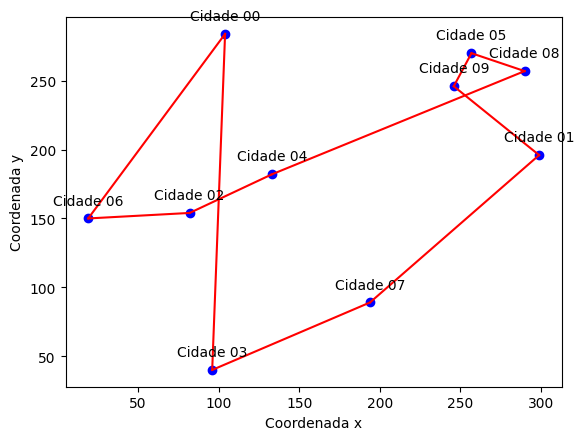

In [8]:
fitness = funcao_objetivo(hall_da_fama)
menor_fitness = min(fitness)
indice = fitness.index(menor_fitness)
melhor_individuo_observado = hall_da_fama[indice]
distancia = funcao_objetivo_caixeiro(melhor_individuo_observado, CIDADES)

print()
print("Melhor individuo obtido por algoritmos genéticos:")
print(melhor_individuo_observado, "com distância:", distancia)
print()

plota_trajeto(CIDADES, melhor_individuo_observado)

### Conclusão
<div style="text-align: justify">

&nbsp;&nbsp;&nbsp;&nbsp;O algoritmo de otimização denominado recozimento simulado possui, assim como os algoritmos genéticos, um caráter inspirado em processos naturais. Dada essa semelhança, propôs-se aqui a integração entre os dois algoritmos, buscando um melhor desempenho na resolução do problema do caixeiro viajante que prefere cidades ímpares.

### Referências

[1]. CARNEIRO, A. L. C. Algoritmos de otimização: Hill Climbing e simulated annealing. Disponível em: <https://medium.com/data-hackers/algoritmos-de-otimiza%C3%A7%C3%A3o-hill-climbing-e-simulated-annealing-3803061f66f0>.

[2] CASSAR, Daniel. [Material de sala de aula]. Redes Neurais e Algoritmos Genéticos, Ilum - Escola de Ciência.